In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import re

### Upload the dataframe

In [4]:
df = pd.read_csv('/content/masked_slack_message.csv')
df2 = pd.read_csv('/content/users_email.csv')

In [6]:
# attach the email address of each user to the slack user_id
merged = df.merge(df2, how='left', left_on='user_id', right_on='id')
merged.head(2)
merged.profile_email.isna().sum()

np.int64(7044)

In [7]:
# Function to classify users based on email domain
def categorize_user(profile_email):
    if pd.isna(profile_email) or profile_email.strip() == "":
        return "Others"
    elif profile_email.strip().endswith("@1beat.com"):
        return "Developer"
    else:
        return "Client"

# Assuming the email column is named 'email'
merged["user_category"] = merged["profile_email"].apply(categorize_user)

## To determine the FAQ, extract messages that contain question mark "?".

In [10]:
# Extract rows where the text contains a question mark (?).
questions = merged[merged["masked_text"].str.contains("\?", na=False)]
question = questions.to_csv('question.csv')

### What proportion of the message contains questions?

In [13]:
# calculate the proportion of messages that contian question marks.
question_ratio = questions.shape[0] / merged.shape[0] * 100
question_ratio

24.362248685890773

## Determine the most common questions by using NLP.

In [48]:
# Use NLP techniques to identify frequently asked questions.
question_list = questions["masked_text"].str.lower().tolist()
common_questions = Counter(question_list).most_common(200)  # Top 10 questions
common_questions_df = pd.DataFrame(common_questions) # converts the list into dataframe
common_questions_df.columns = ['message_text', 'count']
common_questions_df.head()
question_df = common_questions_df.to_csv('question_df.csv')
display(common_questions_df.head())

,message_text,count
0,?,9
1,<!subteam^s03ul52bnmq> can you please check?,8
2,<@u02hctr7fhn> any update?,5
3,<!subteam^s03ul52bnmq> can you please take a l...,5
4,hi <@u031e2ljjet> any update on this?,4


## Determine the most common topics asked by the customers.

### 1. First clean the message_text field by exluding stop words and punctuations.

In [49]:
# Text Preprocessing
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

questions.loc[:,"cleaned_text"] = questions["masked_text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# view the top few rows containing the original text and the cleaned text.
questions[['masked_text','cleaned_text']].head()

,masked_text,cleaned_text
8,[NAME HIDDEN] sent an email *Re: Any update?* ...,name hidden sent email update datenumber hidde...
32,Hello team! <@U06CM7UTA81> <@U02PBFPACUU>\n\nT...,hello team ucmuta upbfpacuu client made two qu...
51,Are you joining the meeting?,joining meeting
53,Hi <@U04CVQHC550> [NAME HIDDEN] didn't send fi...,hi ucvqhc name hidden didnt send files please ...
56,Can you send me the list of all sku's you get?,send list skus get


### 2. Convert the cleaned text into token count metrix using CountVectorizer.

In [17]:
# Convert text into a matrix of token counts
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words="english")
X = vectorizer.fit_transform(questions["cleaned_text"])

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

# Display Topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx+1}:")
    print([feature_names[i] for i in topic.argsort()[-10:]])
    print("\n")

Topic 1:
['want', 'share', 'hiddenlf', 'team', 'time', 'need', 'client', 'hi', 'unumber', 'meeting']


Topic 2:
['issue', 'st', 'today', 'update', 'vis', 'thanks', 'ucbhnfl', 'hi', 'hiddenej', 'unsnumber']


Topic 3:
['inventory', 'product', 'location', 'hiddenthreadtsnumber', 'sku', 'id', 'hiddennumber', 'url', 'number', 'hidden']


Topic 4:
['skus', 'ucbhnfl', 'locations', 'dont', 'inventories', 'location', 'ar', 'inventory', 'need', 'gt']


Topic 5:
['initial', 'days', 'sales', 'stock', 'event', 'ueljjet', 'uhctrfhn', 'store', 'hidden', 'target']


Topic 6:
['hiddengtnumber', 'jun', 'hiddenquoted', 'hiddenzip', 'false', 'hiddengt', 'number', 'quoted', 'text', 'hidden']


Topic 7:
['like', 'list', 'wh', 'stores', 'time', 'sku', 'check', 'skus', 'inventory', 'replenishment']


Topic 8:
['dont', 'process', 'think', 'time', 'know', 'server', 'data', 'hi', 'need', 'client']


Topic 9:
['transactions', 'hi', 'check', 'upload', 'client', 'hiddenlf', 'file', 'files', 'unumber', 'data']


To

### 3. Assign the probability for each rows of cleaned text to the identified 10 topics. ex. the first row has the highest probability to fall under topic 6.

In [18]:
topic_distribution = lda_model.transform(X)
topic_distribution_df = pd.DataFrame(topic_distribution, columns=[f"Topic {i+1}" for i in range(10)])
merged = pd.concat([questions['cleaned_text'], topic_distribution_df], axis=1)
merged.head()

,cleaned_text,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
8,name hidden sent email update datenumber hidde...,0.145906,0.003334,0.003334,0.003335,0.003334,0.580739,0.003334,0.003334,0.250016,0.003333
32,hello team ucmuta upbfpacuu client made two qu...,0.014290,0.014290,0.014291,0.327411,0.014288,0.014287,0.014290,0.558281,0.014287,0.014286
51,joining meeting,0.819975,0.020006,0.020001,0.020002,0.020004,0.020000,0.020003,0.020005,0.020003,0.020000
53,hi ucvqhc name hidden didnt send files please ...,0.010001,0.010005,0.010001,0.010002,0.571968,0.010000,0.010002,0.010002,0.348019,0.010000
56,send list skus get,0.693913,0.007144,0.007144,0.248936,0.007144,0.007143,0.007144,0.007145,0.007144,0.007143


In [50]:
# convert each word obtained from the cleaned_text and convert them to columns. examine eack row of the dataframe against each word to create matrix.
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
X_df.head()

,aa,abastecimiento,ability,able,absence,absolute,ac,accept,acceptable,accepted,...,yoyo,zendesk,zero,zeroed,zeroing,zeros,zip,zipped,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Establish a topic name or category based on words or phrases.

In [52]:
# Define categories and their associated keywords
categories = categories = {
    "Follow-ups": ["any update", "can you check", "can you take a look", "look at this"],
    "Technical Issues": ["error", "issue", "bug", "not working", "fix"],
    "Troubleshooting": ["how can we", "what is causing", "debug", "identify problem"],
    "Process Execution": ["automatic process", "execution", "workflow", "run", "schedule"],
    "System Migration": ["migration", "data transfer", "migrate", "move system"],
    "Responsibility Assignment": ["who is responsible", "lead this", "assign task", "ownership"],
    "Decision Making": ["final decision", "should we proceed", "agreement", "choice"]
}

In [53]:
# Function to categorize each row
def categorize_question(question):
    question_lower = str(question).lower()
    for category, keywords in categories.items():
        if any(keyword in question_lower for keyword in keywords):
            return category
    return "Other"
# Apply the function to create a new 'Category' column
questions["Category"] = questions["masked_text"].apply(categorize_question)

In [54]:
# count the number of rows per question category defined above.
topic_user = questions.groupby('Category')['Category'].count().reset_index(name='count').sort_values(by='count', ascending=False)
topic_user['ratio'] = topic_user['count'] / topic_user['count'].sum() * 100
topic_user

,Category,count,ratio
2,Other,12870,78.442128
6,Technical Issues,1856,11.312245
3,Process Execution,882,5.375754
1,Follow-ups,570,3.474127
7,Troubleshooting,102,0.621686
5,System Migration,73,0.444932
0,Decision Making,50,0.304748
4,Responsibility Assignment,4,0.024380


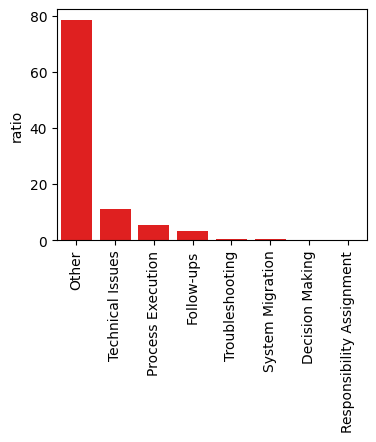

In [58]:
plt.figure(figsize=(4, 3))
sns.barplot(data=topic_user, x='Category',y='ratio', color='red')
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

In [55]:
# how many of the messages have a thread? extract message which has thread or exchange of messages
threads = questions.groupby('thread_ts')['masked_text'].count().sort_values(ascending=False).reset_index(name='count_message')
threads_yes = threads[threads['count_message'] > 1]
threads_yes.shape

(3062, 2)

In [56]:
# filiter only messages that have threads based on the threads_yes thread_ts
questions_threads = questions[questions['thread_ts'].isin(threads_yes['thread_ts'])]
questions_threads.shape

(12450, 25)

In [59]:
# percent of the texts that have a threads from the questions table.
threads_ratio = questions_threads.shape[0] / questions.shape[0] * 100
threads_ratio

75.88224538306821

In [29]:
# Count the number of message categories based on the users category
topic_thread = questions.groupby(['Category','user_category'])['Category'].count().reset_index(name='count')
topic_thread_percent = topic_thread.sort_values(by='count', ascending=False)
topic_thread_percent['ratio'] = topic_thread_percent['count'] / topic_thread_percent['count'].sum() * 100
topic_thread_percent

,Category,user_category,count,ratio
5,Other,Developer,12167,74.157372
14,Technical Issues,Developer,1731,10.550375
8,Process Execution,Developer,853,5.199000
4,Other,Client,592,3.608216
2,Follow-ups,Developer,544,3.315658
6,Other,Others,111,0.676541
17,Troubleshooting,Developer,99,0.603401
15,Technical Issues,Others,76,0.463217
12,System Migration,Developer,72,0.438837
0,Decision Making,Developer,50,0.304748


### Which user sends the most number of questions?

In [60]:
# calculate the message categories per user_category.
topic_user = questions.groupby(['user_category'])['Category'].count().reset_index(name='count')
topic_user

,user_category,count
0,Client,673
1,Developer,15520
2,Others,214
